# Prediction Model
Using real web-scraped ROA, ROE, stock data and dummy ESG core metric scores  
Update to use our real ESG core metric scores please

## Import Libraries and Data

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [132]:
# Load the data (replace with your file paths)
esg_data = pd.read_csv("esg_dataset_2019_2024.csv")
roa_roe = pd.read_csv("roa_roe_table_rows.csv")
stocks = pd.read_csv("stocks_table_rows.csv")

roa_roe["date"] = pd.to_datetime(roa_roe["date"])
roa_roe["year"] = roa_roe["date"].dt.year
stocks["date"] = pd.to_datetime(stocks["date"])
stocks["year"] = stocks["date"].dt.year
stocks["month"] = stocks["date"].dt.month

## Feature Engineering
Transform stock value to stock percentage growth (annual linear return)

In [133]:
# Compute the first (Jan) and last (Dec) stock price for each company-year
prices_year_start = stocks[stocks['month'] == 1].set_index(['company', 'year'])[['close']].rename(columns={'close': 'beginning_price'}).sort_values(by=['company','year'])    
prices_year_end = stocks[stocks['month'] == 12].set_index(['company', 'year'])[['close']].rename(columns={'close': 'ending_price'}).sort_values(by=['company','year'])    

# Merge to get both beginning and ending stock prices
stocks_return = prices_year_start.join(prices_year_end).reset_index()

# Compute annual linear return
stocks_return['stock growth'] = (stocks_return['ending_price'] - stocks_return['beginning_price']) / stocks_return['beginning_price']

stocks_return

,company,year,beginning_price,ending_price,stock growth
0,3M,2016,92.046814,111.769226,0.214265
1,3M,2017,109.422089,150.780930,0.377975
2,3M,2018,160.473434,125.300278,-0.219184
3,3M,2019,131.718506,119.923889,-0.089544
4,3M,2020,107.851250,123.240036,0.142685
...,...,...,...,...,...
322,petrobras,2021,3.606838,4.318497,0.197308
323,petrobras,2022,5.901206,7.631315,0.293179
324,petrobras,2023,8.312044,14.437020,0.736880
325,petrobras,2024,15.431430,11.940595,-0.226216


## Data Cleaning and Joining

In [134]:
# Merge the datasets on company and year
esg_roa_roe = pd.merge(esg_data, roa_roe, on=["company", "year"], how="inner")
esg_financial = pd.merge(esg_roa_roe, stocks_return, on=["company", "year"], how="inner")

# Drop rows (years) where ROA, ROE or stock growth values are missing
esg_financial = esg_financial.dropna(subset=['roa', 'roe', 'stock growth'])
esg_financial = esg_financial.drop(columns = ["date"])

In [135]:
# Convert Certification to categorical variable
esg_financial["Certification"] = esg_financial["Certification"].astype("category")

# Drop categorical variables for regression model
esg_financial_reg = esg_financial.select_dtypes(exclude='category')

## Check for Stationarity and Autocorrelation on Stock Growth
Determines whether we will use lagged stock growth values as a feature

In [136]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    """Performs the Augmented Dickey-Fuller test and prints the results."""
    
    adf_stat, p_value, _, _, critical_values, _ = adfuller(series.dropna())  # Drop NaN to avoid issues
    
    print(f"ADF Statistic: {adf_stat:.6f}")
    print(f"p-value: {p_value:.6f}")
    print("Critical Values:")
    for level, cv in critical_values.items():
        print(f"\t{level}: {cv:.3f}")
    
    # Determine stationarity
    is_stationary = (p_value <= 0.05) and (adf_stat < critical_values["5%"])
    print("\033[32mStationary\033[0m" if is_stationary else "\033[31mNon-stationary\033[0m")

# Apply to Apple stock
company_stocks = stocks_return[stocks_return['company']=="Apple"].dropna()["stock growth"]
check_stationarity(company_stocks)

ADF Statistic: -2.633397
p-value: 0.086289
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
Non-stationary


In [137]:
# Differencing the Data (Second Difference)
company_stocks_diff2 = company_stocks.diff().diff().dropna()
check_stationarity(company_stocks_diff2)

ADF Statistic: -4.040341
p-value: 0.001213
Critical Values:
	1%: -5.354
	5%: -3.646
	10%: -2.901
Stationary


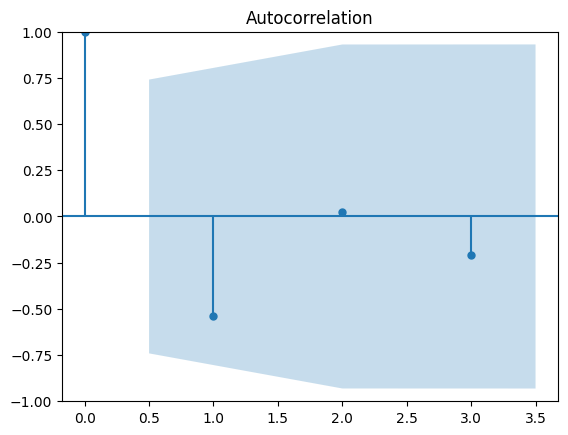

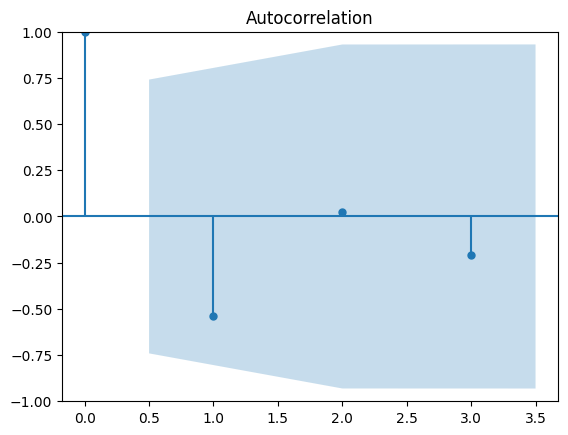

In [138]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(company_stocks_diff)

# Since most values are within the confidence interval (blue region), 
# the stock growth data does not show strong autocorrelation, meaning past values don’t strongly predict future values.
# => Don't use lagged stock growth data in prediction

## ESG-Finance Correlation
How ESG core metrics correlate with financial indicators (ROA, ROE, stock growth)

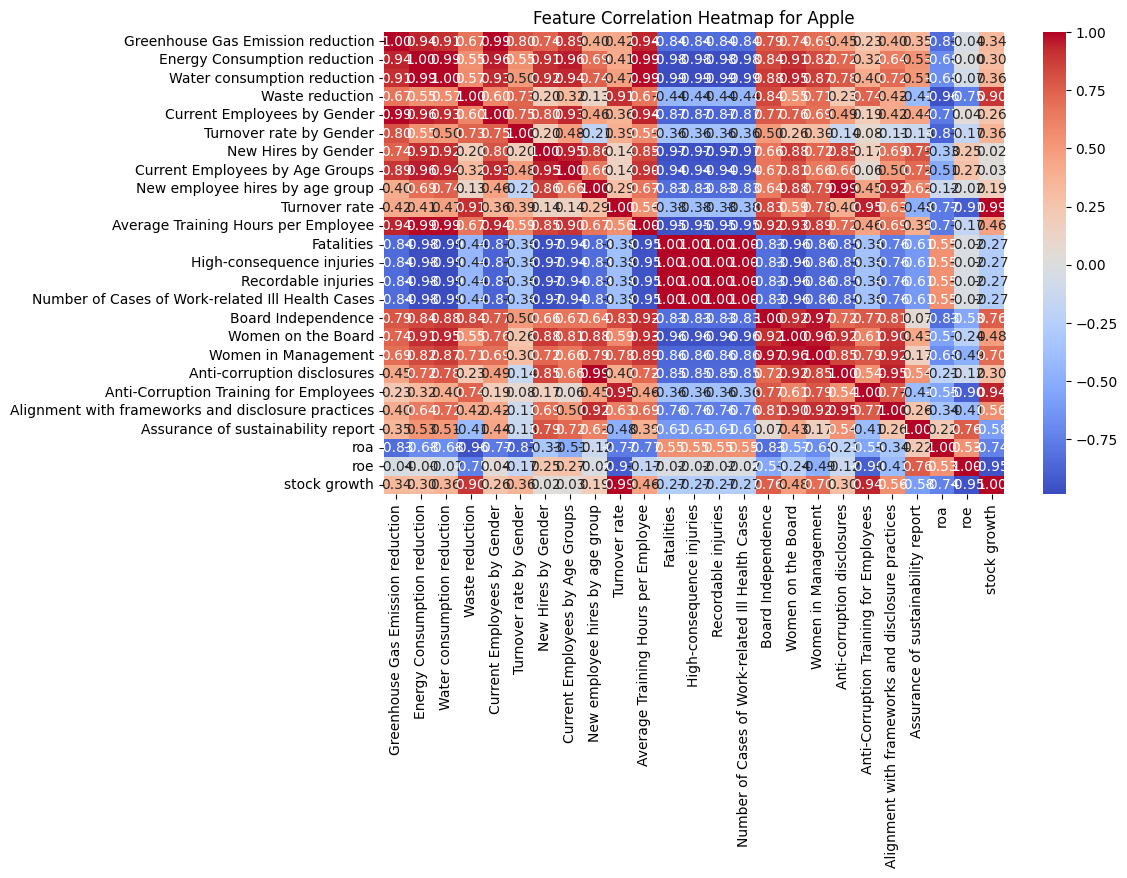

In [139]:
# Compute correlation for each company separately
correlation_results = {}

for company, data in esg_financial_reg.groupby('company'):
    correlation_matrix = data.drop(columns=['company', 'year', 'beginning_price', 'ending_price']).corr()
    correlation_results[company] = correlation_matrix

# Example: Access correlation matrix for company 'Apple'
# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_results['Apple'], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap for Apple")
plt.show()

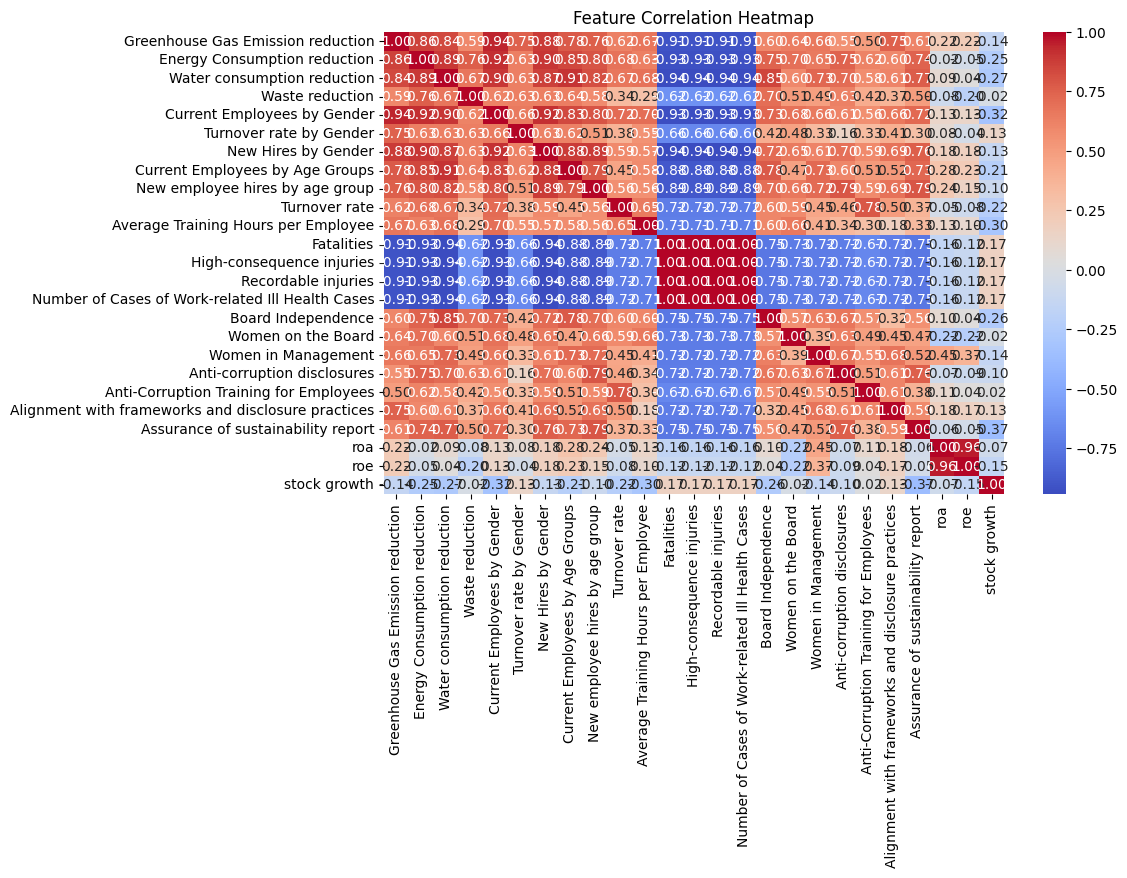

In [140]:
# Compute correlation for all companies
correlation_results = {}
correlation_matrix = esg_financial_reg.drop(columns=['company', 'year', 'beginning_price', 'ending_price']).corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

## Feature Importance using Recursive Feature Elimination
Select features (ESG metrics) that best predict ROA, ROE, stock prices  

Company-wide feature selection

In [141]:
# Define features and targets
features = esg_financial_reg.drop(columns=['roa', 'roe', 'stock growth', 'company', 'year', 'beginning_price', 'ending_price'])
targets = ['roa', 'roe', 'stock growth']

top_features_rfe = {}

for target in targets:
    X = features
    y = esg_financial_reg[target]

    # Fit an approximate linear model
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=5)  # Select top 5 features
    rfe.fit(X, y)

    # Get selected feature names
    selected_features = np.array(features.columns)[rfe.support_]
    top_features_rfe[target] = selected_features.tolist()

print("Top 5 features per target variable using RFE:")
print(top_features_rfe)


Top 5 features per target variable using RFE:
{'roa': ['Current Employees by Gender', 'Turnover rate', 'Average Training Hours per Employee', 'Women on the Board', 'Anti-Corruption Training for Employees'], 'roe': ['Water consumption reduction', 'High-consequence injuries', 'Recordable injuries', 'Number of Cases of Work-related Ill Health Cases', 'Women on the Board'], 'stock growth': ['Water consumption reduction', 'Current Employees by Gender', 'Turnover rate by Gender', 'Board Independence', 'Alignment with frameworks and disclosure practices']}


In [142]:
from collections import Counter

# Combine the selected features from all targets into one list
all_selected_features = top_features_rfe['roa'] + top_features_rfe['roe'] + top_features_rfe['stock growth']

# Count the frequency of each feature
feature_counts = Counter(all_selected_features)

# Sort features by frequency and select the top 5
top_5_features = [feature for feature, count in feature_counts.most_common(5)]
print("Top 5 Features Across All Targets:", top_5_features)


Top 5 Features Across All Targets: ['Current Employees by Gender', 'Women on the Board', 'Water consumption reduction', 'Turnover rate', 'Average Training Hours per Employee']


Industry-based feature selection

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from collections import defaultdict

# Define features and targets
features = esg_financial_reg.drop(columns=['roa', 'roe', 'stock growth', 'company', 'year', 'beginning_price', 'ending_price'])
targets = ['roa', 'roe', 'stock growth']

# Ensure 'industry' column is available
if 'industry' not in esg_financial_reg.columns:
    raise ValueError("The dataset must contain an 'industry' column for industry-based feature selection.")

# Dictionary to store top features per industry
top_features_by_industry = defaultdict(dict)

# Iterate over industries
for industry, industry_data in esg_financial_reg.groupby('industry'):
    industry_features = industry_data.drop(columns=['roa', 'roe', 'stock growth', 'company', 'year', 'beginning_price', 'ending_price', 'industry'])

    for target in targets:
        X = industry_features
        y = industry_data[target]

        # Fit an approximate linear model
        model = LinearRegression()
        rfe = RFE(model, n_features_to_select=5)  # Select top 5 features
        rfe.fit(X, y)

        # Get selected feature names
        selected_features = np.array(industry_features.columns)[rfe.support_]
        top_features_by_industry[industry][target] = selected_features.tolist()

# Print the selected features for each industry
for industry, features in top_features_by_industry.items():
    print(f"Industry: {industry}")
    for target, top_features in features.items():
        print(f"  {target}: {top_features}")

ValueError: The dataset must contain an 'industry' column for industry-based feature selection.

# Linear Regression
Due to a limited historical data, we will use all historical data available to train

In [202]:
# Fitting the model on all data

# Initialize an empty DataFrame to store all results
all_output_data = pd.DataFrame()

print("Model Coefficients:")
      
for company, company_data in esg_financial_reg.groupby('company'):
    company_data = company_data.reset_index()  # Reset index to bring 'year' back as a column
    company_data['time'] = company_data['year'] - company_data['year'].min()
    
    # Make sure 'year' is a column and not part of the index
    company_data['year'] = pd.to_datetime(company_data['year'], format='%Y').dt.year

    print("\n", company, "\n")
    # Use 'time', 'esg_metric' as features, and 'roa', roe', 'stock growth' as target
    for esg_metric in top_5_features:
        endog = company_data[['roa', 'roe', 'stock growth']].dropna()  # Target variables
        exog = company_data[['time', esg_metric]].dropna()  # Features (time and ESG metric)
        
        # Ensure both target and exogenous variables have the same number of rows
        common_index = endog.index.intersection(exog.index)
        endog = endog.loc[common_index]
        exog = exog.loc[common_index]
        
        model = LinearRegression()
        model.fit(exog, endog)

        print(esg_metric, "\n", model.coef_)  # Prints model coeff for ROA, ROE and Stock Price coeff
    
        # Forecasting the next 5 years (based on 'time' index)
        forecast_steps = 6
        latest_time = exog['time'].iloc[-1]
        future_time = np.arange(latest_time, latest_time + forecast_steps).reshape(-1, 1)
        latest_esg = exog[esg_metric].iloc[-1]
        
        # Convert future 'time' back to years
        future_years = company_data['year'].min() + future_time.flatten()
           
        # **Consistent ESG Model**: Use the latest ESG value for all forecast years
        consistent_esg = np.full((forecast_steps, 1), latest_esg)

        # **Increasing ESG Model**: Increase the ESG value gradually by 0.1 each year, max value capped at 10
        increasing_esg = np.minimum(latest_esg + np.arange(forecast_steps) * 0.1, 10.0).reshape(-1, 1)

        # Combine future years with ESG values for both scenarios
        consistent_forecast_exog = np.hstack([future_time, consistent_esg])
        increasing_forecast_exog = np.hstack([future_time, increasing_esg])

        # Convert to DataFrames with appropriate column names
        consistent_exog_df = pd.DataFrame(consistent_forecast_exog, columns=['time', esg_metric])
        increasing_exog_df = pd.DataFrame(increasing_forecast_exog, columns=['time', esg_metric])

        # Predict the future values using the trained model for both consistent and increasing ESG
        consistent_forecast = model.predict(consistent_exog_df)
        increasing_forecast = model.predict(increasing_exog_df)
        
        # Create DataFrames for the forecast results
        consistent_forecast_df = pd.DataFrame(consistent_forecast, columns=endog.columns)
        increasing_forecast_df = pd.DataFrame(increasing_forecast, columns=endog.columns)
        
        # Add scenario details
        consistent_forecast_df['scenario'] = 'Consistent ESG'
        increasing_forecast_df['scenario'] = 'Increasing ESG'

        # Add ESG metric and company details
        consistent_forecast_df['esg metric'] = esg_metric
        increasing_forecast_df['esg metric'] = esg_metric
        consistent_forecast_df['metric score'] = latest_esg
        increasing_forecast_df['metric score'] = increasing_esg.flatten()
        consistent_forecast_df['company'] = company
        increasing_forecast_df['company'] = company
        
        # Forecasted years
        forecast_years = future_years
        consistent_forecast_df['year'] = forecast_years
        increasing_forecast_df['year'] = forecast_years
        
        # Add historical data for the company
        historical = company_data.copy()
        historical['scenario'] = 'Historical'
        historical['esg metric'] = esg_metric
        historical['metric score'] = company_data[esg_metric]
        historical = historical.reset_index()

        # Concatenate historical data and forecasted data
        output_data = pd.concat([
            historical[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']],
            consistent_forecast_df[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']],
            increasing_forecast_df[['company', 'year', 'roa', 'roe', 'stock growth', 'esg metric', 'metric score', 'scenario']]
        ])
        
        # Append to the overall output DataFrame
        all_output_data = pd.concat([all_output_data, output_data])

# Save the output to a CSV file
all_output_data.to_csv('model_prediction_with_time_and_esg_scenarios.csv', index=False)

# Print the output data for verification
#print(all_output_data)

Model Coefficients:

 Apple 

Current Employees by Gender 
 [[ 0.00466711 -0.67528881]
 [-0.01156727  1.03203086]
 [ 0.03681607  1.8695754 ]]
Women on the Board 
 [[ 9.32411893e-05 -2.79418972e-01]
 [ 4.68013170e-01 -2.73675334e+01]
 [-5.43792132e-01  3.56657872e+01]]
Water consumption reduction 
 [[  0.03685171  -1.66361973]
 [  0.50198723 -20.01114693]
 [ -0.75873247  32.91875712]]
Turnover rate 
 [[-2.52504760e-03 -4.77704101e-01]
 [ 6.90289111e-02 -1.48609328e+01]
 [-3.06508409e-02  2.08948761e+01]]
Average Training Hours per Employee 
 [[ 1.80023297e-02 -1.49497279e+00]
 [ 3.21917171e-01 -2.10610989e+01]
 [-4.44330664e-01  3.34463603e+01]]

 Capgemini 

Current Employees by Gender 
 [[ 2.97108271e-03  3.35675478e-01]
 [-2.17361130e-02  1.53059480e+00]
 [ 9.37080996e-01 -6.65645323e+01]]
Women on the Board 
 [[ 6.23029880e-03  2.55937815e-01]
 [-9.95562051e-03  1.53404969e+00]
 [ 1.96498803e-01 -3.95200540e+01]]
Water consumption reduction 
 [[ 1.28463725e-02 -1.51720067e-01]
 [ 3.

## Visualising the Results

In [194]:
# Filter data for Apple
apple_data = all_output_data[all_output_data['company'] == 'Apple']

# Select relevant columns (historical values + ESG metric)
historical_data = apple_data[apple_data['scenario'] == 'Historical']
consistent_esg_data = apple_data[apple_data['scenario'] == 'Consistent ESG']
improved_esg_data = apple_data[apple_data['scenario'] == 'Increasing ESG']

# Assume 'Current Employees by Gender' is one of the ESG metrics
esg_metric = 'Current Employees by Gender'  # Update this if needed
historical_esg = historical_data[historical_data['esg metric'] == esg_metric]
consistent_esg = consistent_esg_data[consistent_esg_data['esg metric'] == esg_metric]
improved_esg = improved_esg_data[improved_esg_data['esg metric'] == esg_metric]

improved_esg

,company,year,roa,roe,stock growth,esg metric,metric score,scenario
0,Apple,2024,0.257939,1.682784,0.313201,Current Employees by Gender,0.700074,Increasing ESG
1,Apple,2025,0.195077,1.774420,0.536974,Current Employees by Gender,0.800074,Increasing ESG
2,Apple,2026,0.132215,1.866056,0.760748,Current Employees by Gender,0.900074,Increasing ESG
3,Apple,2027,0.069353,1.957692,0.984521,Current Employees by Gender,1.000074,Increasing ESG
4,Apple,2028,0.006492,2.049327,1.208295,Current Employees by Gender,1.100074,Increasing ESG
5,Apple,2029,-0.056370,2.140963,1.432069,Current Employees by Gender,1.200074,Increasing ESG


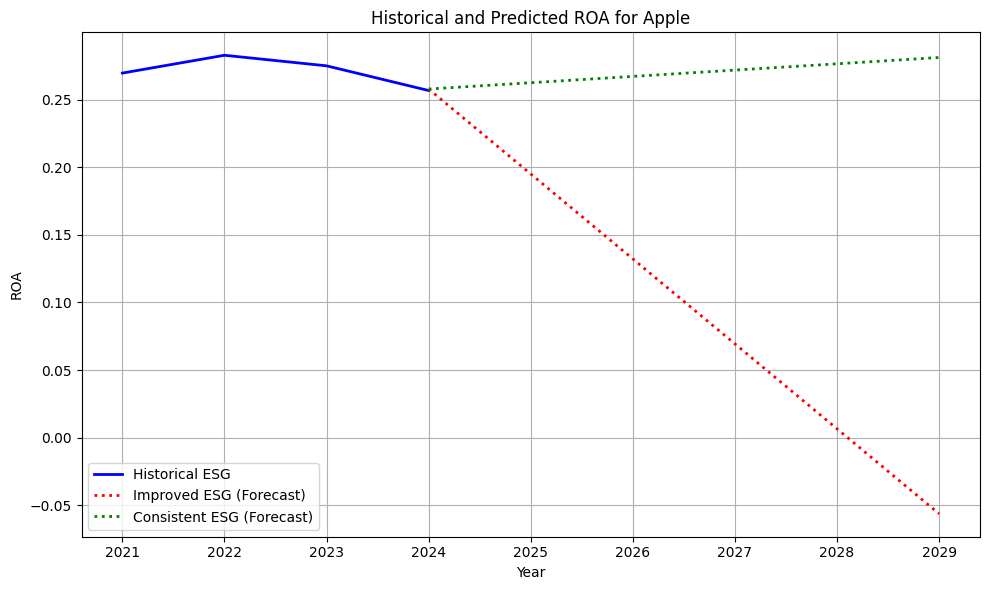

In [195]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(historical_esg['year'], historical_esg['roa'], label='Historical ESG', color='blue', linewidth=2)

# Plot improved ESG forecast (dotted red line)
plt.plot(improved_esg['year'], improved_esg['roa'], label='Improved ESG (Forecast)', color='red', linestyle='dotted', linewidth=2)

# Plot consistent ESG forecast (dotted green line)
plt.plot(consistent_esg['year'], consistent_esg['roa'], label='Consistent ESG (Forecast)', color='green', linestyle='dotted', linewidth=2)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('ROA')
plt.title('Historical and Predicted ROA for Apple')

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()